# Overview -- Cone and Rod Photoreceptor Classification 
The aim here is to perform binary classification on cells identified in 
Adaptive Optics Scanning Laser Ophthalmoscopy (AO-SLO) images of the human retina. This 
classification is typically performed manually, which is a slow and tedious task; 
it is also highly subjective. It is common for results from different trained reviewers to differ by >10%. 
Hence an automated approach is highly desirable not simply to save time but also to potentially improve
the reliability and subjectivity of results.

### Adaptive Optics (AO) Imaging
Adaptive Optics (AO) is a state-of-the-art ultra-high-resolution imaging technique that uses a deformable mirror and wavefront sensor to measure and correct for imaging beam aberrations (in real-time). For images of the human retina, this means individual cells (such as cone and rod photoreceptors) are now able to be seen in living eyes. All prior imaging of such cells had occurred post mortem (diseased eyes).

Despite the excitement of simply being able to see these cells, **major challenges remain--largely surrounding the interpretation and analysis of such images**. Much of my work in recent years involved (first) manually identifying and (later) automating the identification of cells and lesions in AO images of health and diseased eyes.

### Machine Learning

This notebook presents a machine learning approach this problem. This task was initiated in the summer of 2017 using 
Matlab and its built-in toolboxes. The current notebook represents recent updates to that work, using Python and Scikit-learn. New to the current version is some feature engineering (e.g. SMOTE technique) and adoption of a random forest classifier as opposed to the original logistic regression approach. The original images are not currently available, but can be seen in this publication:

**Wells-Gray, E. M.**, *et al. "Variation in rod and cone density from the fovea to the mid-periphery in healthy human retinas using adaptive optics scanning laser ophthalmoscopy." Eye 30.8 (2016): 1135.*

### Pre-processing the images

The dataset analyzed below presents features for cells classified as "cone" or "rod" by an expert reviewer familiar with AO-SLO structural characteristics of retinal cells. The images were first registered to correct for eye-motion using a strip-correlation approach and then averaged to improve signal-to-noise ratio. These pre-processed registered-averaged AO-SLO images were then fed into a cell identification routine that identified all cells based on presence of local intensity maxima satisfying intensity and spacing thresholds.  

In [34]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score,recall_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

## Data preparation and analysis

The target variable "type" referes to whether the cell was classified as cone (type=1) or
rod (type=0). The three features include "intensity": the pixel intensity and the center of the identified cell; "NN1": distance in pixels to the (one) nearest neighboring cell; and "slope" the radial average intensity slope (intensity drop per pixel) at a distance of 3 pixels from cell center.

In [21]:
# read in csv file with photoreceptor features and classiciation targets
df = pd.read_csv("cell_data.csv", index_col=0)
df.head()

,type,intensity,NN1,slope
0,1.0,1500.405894,11.809860,204.908113
1,1.0,2067.026429,11.438212,130.376722
2,0.0,1769.137425,8.013123,39.994223
3,0.0,1678.154668,7.694492,22.105773
4,0.0,1010.562769,8.524414,27.175488


Text(0.5,0,'value')

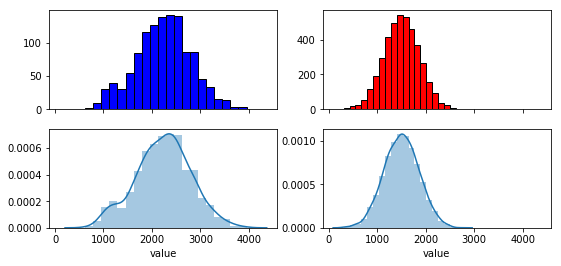

In [36]:
df_cones = df.loc[df.type==1]
df_rods = df.loc[df.type==0]




In [41]:
def plot_cones_rods(att_cone, att_rod, xlabel):
    fig,axes = plt.subplots(2,2,figsize=(9,4),sharex=True)
    axes[0,0].hist(att_cone,20,color='blue', edgecolor='black')
    axes[0,1].hist(att_rod,20,color='red', edgecolor='black')
    plt.sca(axes[1,0])
    sn.distplot(att_cone,bins=20)
    plt.sca(axes[1,1])
    sn.distplot(att_rod,bins=20)
    #plt.hist(dist,40,color=color, edgecolor='black')
    axes[1,0].set_xlabel(xlabel)
    axes[1,1].set_xlabel(xlabel)
    axes[0,0].set_title("Cones "+xlabel)
    axes[0,1].set_title("Rods "+xlabel)

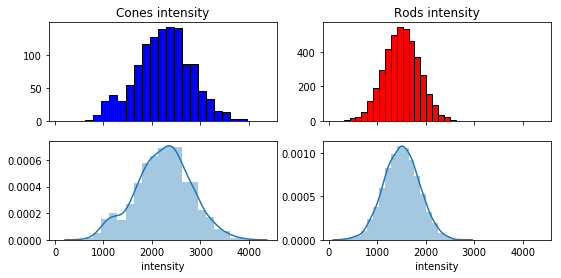

In [42]:
plot_cones_rods(df_cones.intensity, df_rods.intensity,"intensity")

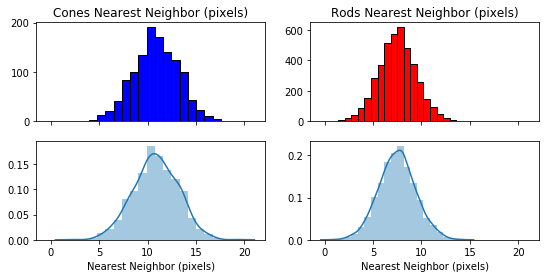

In [44]:
plot_cones_rods(df_cones.NN1, df_rods.NN1,"Nearest Neighbor (pixels)")

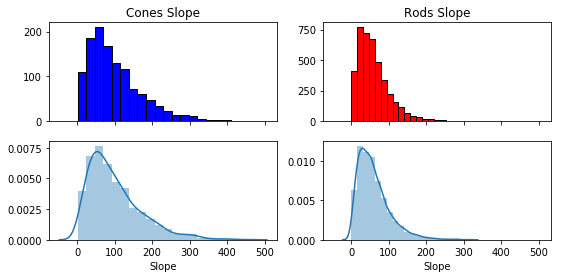

In [45]:
plot_cones_rods(df_cones.slope, df_rods.slope,"Slope")

In [18]:
# "type" is 1 for cones, 0 for rods. This is the target variable
y_all = df.type
X_all = df.copy()
X_all.drop(["type"], axis=1, inplace=True)

x_train, x_valid, y_train, y_valid = train_test_split(X_all,y_all, test_size=0.2, random_state=42)
x_train.head()

In [4]:
clf = LogisticRegression(random_state=0, solver='liblinear', multi_class='ovr')
clf.fit(x_train,y_train)

y_predict = clf.predict(x_valid)

auc = roc_auc_score(y_valid, y_predict)
print('AUC (  no_scaling )=',round(auc,5))
recall = recall_score(y_valid, y_predict)
print('Recall( no scaling )',round(recall,5))

AUC (  no_scaling )= 0.84521
Recall( no scaling ) 0.71146


In [5]:
model = LogisticRegression(random_state=0, solver='liblinear', multi_class='ovr')
clf2 = Pipeline(steps = [('scaler',StandardScaler()),('model',model)])

clf2.fit(x_train,y_train)

y_predict2 = clf2.predict(x_valid)
auc = roc_auc_score(y_valid, y_predict2)
print('AUC (stand.scaler)=',round(auc,5))
recall = recall_score(y_valid, y_predict2)
print('Recall(stand.scaler)',round(recall,5))

AUC (stand.scaler)= 0.84607
Recall(stand.scaler) 0.71937


In [6]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization


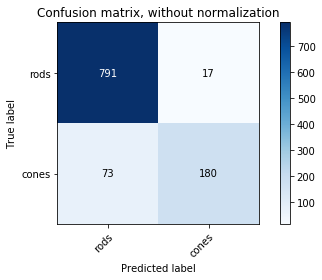

In [7]:
cm = confusion_matrix(y_valid, y_predict)
plot_confusion_matrix(y_valid, y_predict, classes=['rods','cones'],
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues)

In [8]:
# Use SMOTE algorithm to over-sample the cones
# Note: MUST over-sample AFTER splitting the test/val sets so test information 
# does not "bleed" in to the validation data

sm = SMOTE(random_state=0, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

model = LogisticRegression(random_state=0, solver='liblinear', multi_class='ovr')
model.fit(x_train_res,y_train_res)
 
y_predict_res = model.predict(x_valid)
 
auc = roc_auc_score(y_valid, y_predict_res)
print('AUC (SMTOE)=',round(auc,5))
recall = recall_score(y_valid, y_predict_res)
print('Recall(SMOTE)',round(recall,5))

AUC (SMTOE)= 0.85464
Recall(SMOTE) 0.81818


AUC (SMTOE+rescale)= 0.86068
Recall(SMOTE+rescale) 0.83399
Normalized confusion matrix


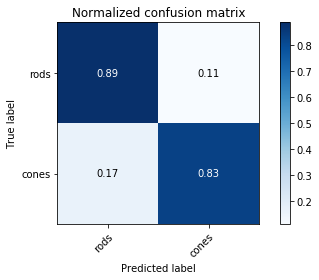

In [9]:
sc = StandardScaler()
x_train_sc = sc.fit_transform(x_train) 
x_valid_sc = sc.transform(x_valid) 

sm2 = SMOTE(random_state=0, ratio = 1.0)
x_train_sc_res, y_train_res = sm.fit_sample(x_train_sc, y_train)

model3 = LogisticRegression(random_state=0, solver='liblinear', multi_class='ovr')
model3.fit(x_train_sc_res, y_train_res)
y_predict_sc_res = model3.predict(x_valid_sc)

auc2 = roc_auc_score(y_valid, y_predict_sc_res)
print('AUC (SMTOE+rescale)=',round(auc2,5))
recall2 = recall_score(y_valid, y_predict_sc_res)
print('Recall(SMOTE+rescale)',round(recall2,5))

cm = confusion_matrix(y_valid, y_predict_sc_res)
plot_confusion_matrix(y_valid, y_predict_sc_res, classes=['rods','cones'],
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)

AUC (SMTOE+rescale)= 0.86639
Recall(SMOTE+rescale) 0.81818
Normalized confusion matrix


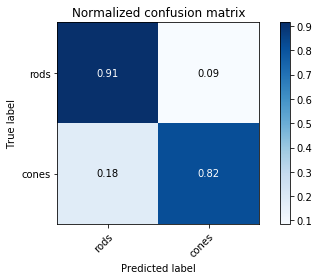

In [10]:
clf_rf = RandomForestClassifier(n_estimators=25, random_state=0)

clf_rf.fit(x_train_sc_res, y_train_res)
y_predict_clf_rf = clf_rf.predict(x_valid_sc)

auc_rf = roc_auc_score(y_valid, y_predict_clf_rf)
print('AUC (SMTOE+rescale)=',round(auc_rf,5))
recall_rf = recall_score(y_valid, y_predict_clf_rf)
print('Recall(SMOTE+rescale)',round(recall_rf,5))

cm = confusion_matrix(y_valid, y_predict_clf_rf)
plot_confusion_matrix(y_valid, y_predict_clf_rf, classes=['rods','cones'],
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)